<a href="https://colab.research.google.com/github/brunotech/BioBERTpt/blob/master/Otimizacao_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se necessário copie este colab para o seu google drive:

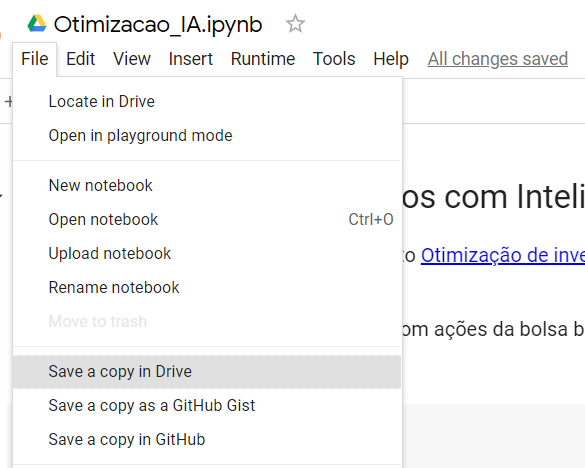

# Otimização de investimentos com Inteligência Artificial

Esse Google Colab contém o código do texto [Otimização de investimentos com Inteligência Artificial](https://medium.com/turing-talks/otimiza%C3%A7%C3%A3o-de-investimentos-com-intelig%C3%AAncia-artificial-548cf34dad4d). O projeto foi implementado por [Lucas Leme Santos](https://www.linkedin.com/in/lucas-leme-santos/).

Para realizar a otimização da sua carteira com ações da bolsa brasileira execute (**Ctrl + Enter** ou **botão de play**) as células com código de programação.

In [ ]:
!pip install yfinance --quiet

import seaborn as sns
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

## Insira as ações da sua carteira!

Coloque 'Ticker + .SA'. Para adicionar mais ações coloque entre vírgulas



```
ações = ['ACAO1.SA', 'ACAO2.SA', 'ACAO3.SA']
```



In [ ]:
ações = ['PETR4.SA', 'BPAC11.SA', 'ITUB4.SA', 'HGLG11.SA', 'VIVT3.SA']

[*********************100%***********************]  5 of 5 completed


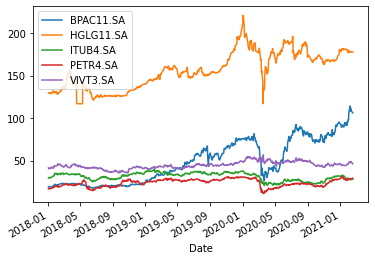

,BPAC11.SA,HGLG11.SA,ITUB4.SA,PETR4.SA,VIVT3.SA
Date,,,,,
2018-01-02,18.90,129.602997,29.253332,16.549999,41.400002
2018-01-03,19.08,129.899994,29.453333,16.700001,40.200001
2018-01-04,19.15,129.998993,30.066666,16.730000,40.639999
2018-01-05,18.77,130.000000,30.153334,16.830000,40.740002
2018-01-08,19.00,130.000000,30.053333,17.030001,41.169998


In [ ]:
# Aquisição de dados
preços = yf.download(ações).Close.loc['2018':].dropna()

preços.plot()
plt.show()

preços.head()

In [ ]:
retornos = preços.pct_change().iloc[1:]
retornos.head()

,BPAC11.SA,HGLG11.SA,ITUB4.SA,PETR4.SA,VIVT3.SA
Date,,,,,
2018-01-03,0.009524,0.002292,0.006837,0.009064,-0.028986
2018-01-04,0.003669,0.000762,0.020824,0.001796,0.010945
2018-01-05,-0.019843,0.000008,0.002883,0.005977,0.002461
2018-01-08,0.012254,0.000000,-0.003316,0.011884,0.010555
2018-01-09,-0.006842,-0.007615,-0.010870,0.000000,-0.002672


In [ ]:
def matrix_seriation(retornos: pd.DataFrame):

  matriz_covarianca = retornos.cov()

  dendograma = sns.clustermap(matriz_covarianca, method='ward', metric='euclidean')

  colunas_seriation = dendograma.dendrogram_col.reordered_ind

  colunas_seriation = retornos.columns[colunas_seriation]

  return (matriz_covarianca, colunas_seriation)

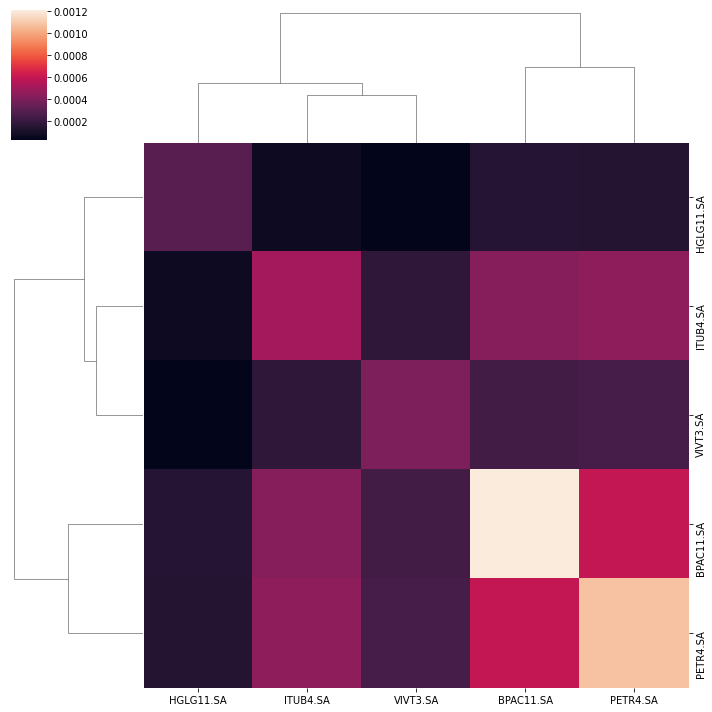

In [ ]:
matriz_cov, colunas_seriation = matrix_seriation(retornos)

In [ ]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

In [ ]:
calcula_pesos_hrp(matriz_cov, colunas_seriation) * 100

HGLG11.SA    40.798358
ITUB4.SA     24.053179
VIVT3.SA     23.956505
BPAC11.SA     5.287635
PETR4.SA      5.904322
dtype: float64

Esse é o resultado da otimização da sua carteira. Os valores estão em porcentagem